In [1]:
import sklearn
import sklearn.model_selection

In [2]:
from sklearn.model_selection  import train_test_split

In [3]:
import pandas as pd

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
df_result = pd.read_csv('df_result_sums.csv')

Сейчас мы будем прогонять полученные датасеты через модели мо. Мною были выбраны две популярные модели, частичтно потому, что я встретила их в статье с похожим заданием https://link.springer.com/article/10.1007/s11634-012-0121-3, и частично из сооображений, того что это две самые простые модели классификации.

Вся задача на этом этапе сводится к бинарной классификации + данные у нас не большие, можно не награждать сложных архитектур.

В качестве фич я взяла численные характеристики, которые по моему мнению, отражют поведение клиента:

Период =4 месяца до предполагаемого ухода

1) total_num_chqs - количество покупок за наблюдаемый период

2) total_num_days - количество раз заходов в магазин (например чек если мы заходили два раза в 23/12/20 то мы считаем за один раз6 по количеству уникальных дат)

3) num_unique_goods - сколько всего было куплено уникальных продуктов за весь период

4) total_money_spent - сколько денег потрачено за весь период

5) total_is_promo_sum - сколько денег потрачено за весь период на акционные товары

6) trend_coef очень игрушечная фича, и если честно я в ней сомневаюсь. Она представляет собой разность суммы  \заходов в первый и последний месяц, деленное на среднее за весь период (в результирующем датасете я выкину эту х-ку, тк неразумно брать среднее от сумм и заходов в магазин.

7) sparsity - количество пустых недель (без транзакций) деленное на 16

Вышло так, чтоклассы у нас практически сбалансированны, что сложно назвать разумным результатом. В общем случае предполагается, что процент оттока не превашает 20%. Такая задача несбалансированна и надо рескейлить классы. В данном случае, я downsample больший класс

Сейчас мы будем работать с датасетом с суммами

In [46]:
df_result.columns

Index(['Unnamed: 0', 'client_id', 'total_num_chqs', 'total_num_days',
       'num_unique_goods', 'total_money_spent', 'total_is_promo_sum',
       'trend_coef', 'sparsity', 'gone'],
      dtype='object')

In [48]:
# X = df_result[['total_num_chqs', 'total_num_days', 'num_unique_goods',
#        'total_money_spent', 'total_is_promo_sum', 'trend_coef', 'sparsity']]

def downsample_train_test_split(df_result, test_size=0.4, random_state=40, trend_coef=True):
    df_result =df_result.dropna()
    y = df_result['gone']
    w_class_gone = np.where(y == 1)[0]
    w_class_stayed = np.where(y == 0)[0]
    
    n_class0 = len(w_class_gone)
    n_class1 = len(w_class_stayed)
    
    w_class_stayed_downsampled = np.random.choice(w_class_stayed, size=n_class0, replace=False)
    
    idx_arr = np.concatenate((w_class_gone, w_class_stayed_downsampled))
    
    X_n = df_result[df_result.index.isin(idx_arr)]
    
    y_n = X_n['gone']
    
    if trend_coef:
        X_n = X_n[['total_num_chqs', 'total_num_days', 'num_unique_goods',
           'total_money_spent', 'total_is_promo_sum', 'trend_coef', 'sparsity']]
    else:
        X_n = X_n[['total_num_chqs', 'total_num_days', 'num_unique_goods',
           'total_money_spent', 'total_is_promo_sum', 'sparsity']]
        
    X_train, X_test, y_train, y_test = train_test_split(X_n, y_n,
                                                        test_size=test_size,
                                                        random_state=random_state)
    return X_train, X_test, y_train, y_test

In [49]:
X_train, X_test, y_train, y_test = downsample_train_test_split(df_result,  trend_coef=True)



In [50]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [51]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)


In [52]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

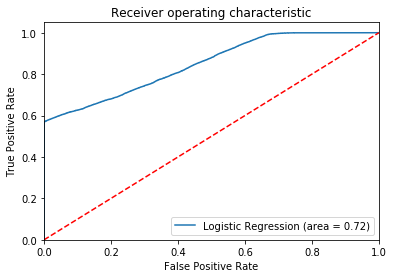

In [53]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


In [54]:
logit_roc_auc



0.7189941448649722

In [57]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

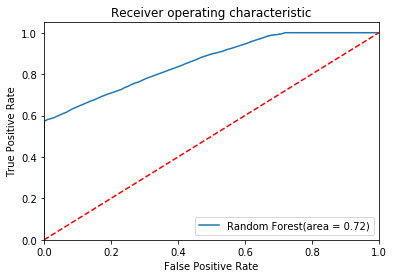

In [58]:
logit_roc_auc_rf = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest(area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('LRF_ROC')
plt.show()

In [59]:
logit_roc_auc_rf

0.7860312764158919

Сейчас сделаем все то же самое для датасета с заходами

In [47]:
df_result_chqs = pd.read_csv('df_result_chqs.csv')

In [62]:
X_train_chqs, X_test_chqs, y_train_chqs, y_test_chqs = downsample_train_test_split(df_result_chqs,  trend_coef=True)

In [63]:
clf_chqs = LogisticRegression(random_state=1).fit(X_train_chqs, y_train_chqs)


/Users/Anna.Rudenko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


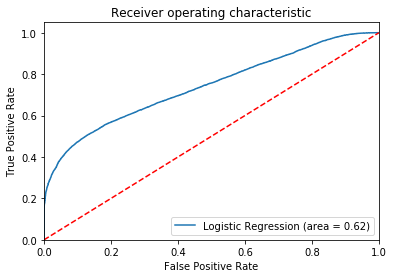

In [64]:
logit_roc_auc = roc_auc_score(y_test_chqs, clf_chqs.predict(X_test_chqs))
fpr, tpr, thresholds = roc_curve(y_test_chqs, clf_chqs.predict_proba(X_test_chqs)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [68]:
rf_chqs = RandomForestClassifier(max_depth=2, random_state=0)
rf_chqs.fit(X_train_chqs, y_train_chqs)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

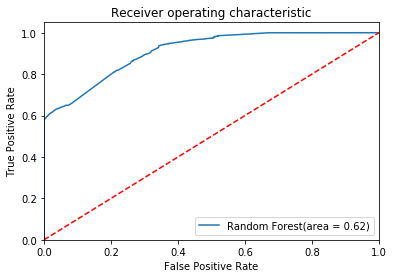

In [69]:
logit_roc_auc_rf = roc_auc_score(y_test_chqs, rf_chqs.predict(X_test_chqs))
fpr, tpr, thresholds = roc_curve(y_test_chqs, rf_chqs.predict_proba(X_test_chqs)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest(area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('LRF_ROC')
plt.show()


И для объединенного датасета :


In [70]:
df_result_union = pd.read_csv('mean_data_of_sums_chqs.csv')

In [84]:
X_train_union, X_test_union, y_train_union, y_test_union = downsample_train_test_split(df_result_union,
                                                                                   trend_coef=False)

In [85]:
clf_union = LogisticRegression(random_state=2).fit(X_train_union, y_train_union)


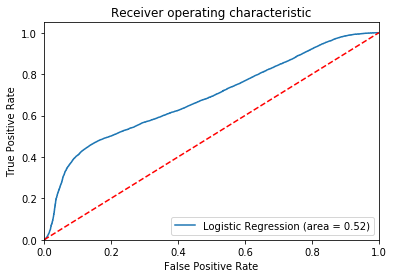

In [86]:
logit_roc_auc = roc_auc_score(y_test_union, clf_union.predict(X_test_union))
fpr, tpr, thresholds = roc_curve(y_test_union, clf_union.predict_proba(X_test_union)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [87]:
rf_union = RandomForestClassifier(max_depth=2, random_state=2).fit(X_train_union, y_train_union)

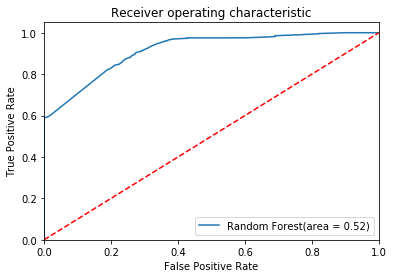

In [88]:
logit_roc_auc_rf = roc_auc_score(y_test_union, rf_union.predict(X_test_union))
fpr, tpr, thresholds = roc_curve(y_test_union, rf_union.predict_proba(X_test_union)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest(area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('LRF_ROC')
plt.show()